# analyzeCNSNetwork 5/13/2022
## by Amber de Neve

This script (analyzeCNSNetwork.ipynb) reads in the adjacency list generated by CompareCNS.pl to create a graph. Each node on the graph is a CNS (Conserved Non-coding sequence) and edge weights are blast similarity scores between CNSs.

Use the docker container aednv/networkx-docker to run this script, or install the networkx package and its dependencies with python 3.8 or above. See the NetworkX website for more install info.

For Bartlett lab: Make sure to use the networkx-docker.simg with the test queue in OpenOnDemand. Other queues don't have a high enough linux version.

## 1. Read graph from adjacency list

In [1]:
#import libraries
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [5]:
#read in the graph from the adjaceny list
G = nx.read_weighted_edgelist("adjacencyList.txt")
print("CNS nodes: " + str(G.order())) #nodes
print("connections: " + str(G.size())) #edges

CNS nodes: 64977
connections: 197353


## 2. Looking more closely at number of connections per CNS node (unfiltered graph)

In [3]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)

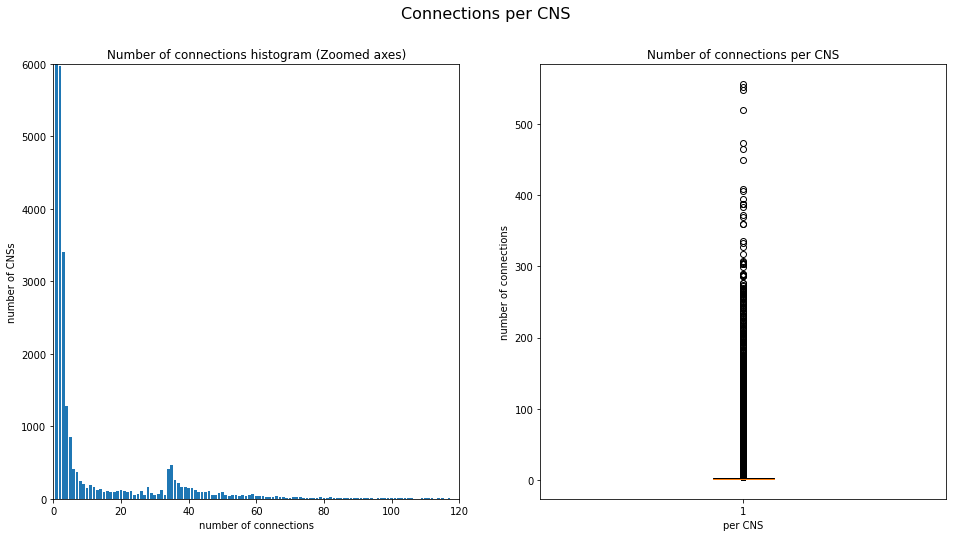

In [46]:
#plotting edge connections
fig = plt.figure("CNS Connections", figsize=(16,8))
fig.suptitle("Connections per CNS", fontsize=16)

ax= fig.add_subplot(121)
ax1= fig.add_subplot(122)
ax.bar(*np.unique(degree_sequence, return_counts=True))

ax.set(ylim=(0,6000),xlim=(0,120))
ax.set_xlabel("number of connections")
ax.set_ylabel("number of CNSs")
ax.set_title("Number of connections histogram (Zoomed axes)")

ax1.boxplot(degree_sequence)
ax1.set_xlabel("per CNS")
ax1.set_ylabel("number of connections")
ax1.set_title("Number of connections per CNS")
plt.show()

In [ ]:
pd.DataFrame(degree_sequence).describe() #most CNSs have only one connection to another CNS

In [ ]:
np.unique(degree_sequence, return_counts=True) 
#looking more closely at counts. Top array is connection num, bottom is number of nodes with that number.
#Out of 65k total nodes, 45k have 1 connection, 6k have 2 connections, 3.5k have 3 connections. 
#There are a lot of outliers with 150+ connections.

## 3. Filter graph to only keep CNS connections between different species

In [21]:
#remove all same species edges. If nodes only have same species edges remove node
print("original connection number" + str(G.size()))
G_itr = G.adjacency()
for node, nbrdict in G_itr:
    #if first 3 letters of node label match other node label, remove the edge (First 3 letters relate to species)
    keys = nbrdict.keys()
    remove_edges = []
    for key in keys:
        if node[0:3] == key[0:3]:
            remove_edges.append(key)
    for re in remove_edges:
        G.remove_edge(node,re)
G.remove_nodes_from(list(nx.isolates(G)))
print("updated connection number" + str(G.size()))

197353
22017


In [22]:
G.order() #new number of nodes

10930

## 4. Looking at number of connections per node on filtered graph

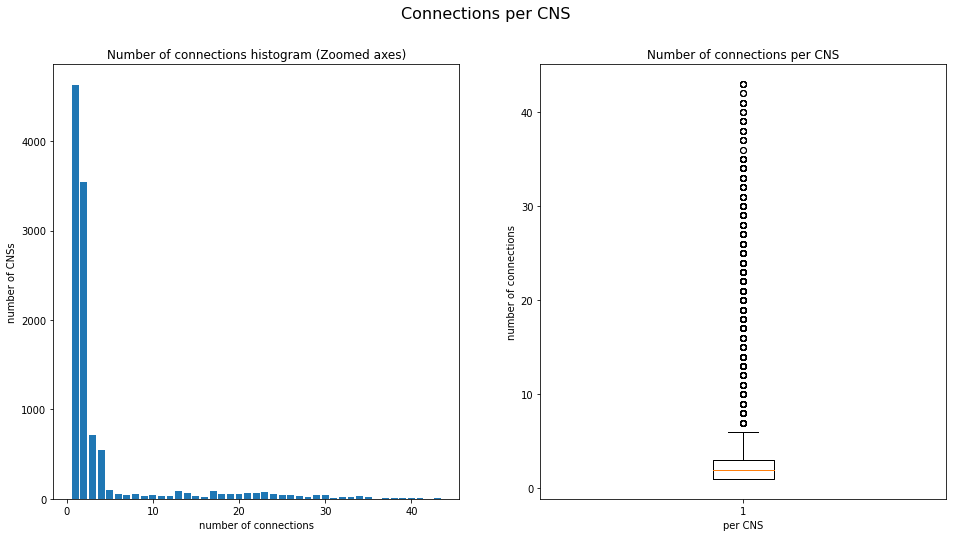

In [24]:
#plotting edge connections
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
fig = plt.figure("CNS Connections", figsize=(16,8))
fig.suptitle("Connections per CNS", fontsize=16)

ax= fig.add_subplot(121)
ax1= fig.add_subplot(122)
ax.bar(*np.unique(degree_sequence, return_counts=True))

ax.set_xlabel("number of connections")
ax.set_ylabel("number of CNSs")
ax.set_title("Number of connections histogram (Zoomed axes)")

ax1.boxplot(degree_sequence)
ax1.set_xlabel("per CNS")
ax1.set_ylabel("number of connections")
ax1.set_title("Number of connections per CNS")
plt.show()

In [ ]:
pd.DataFrame(degree_sequence).describe()

## 5. Plotting the filtered graph (~10k nodes)

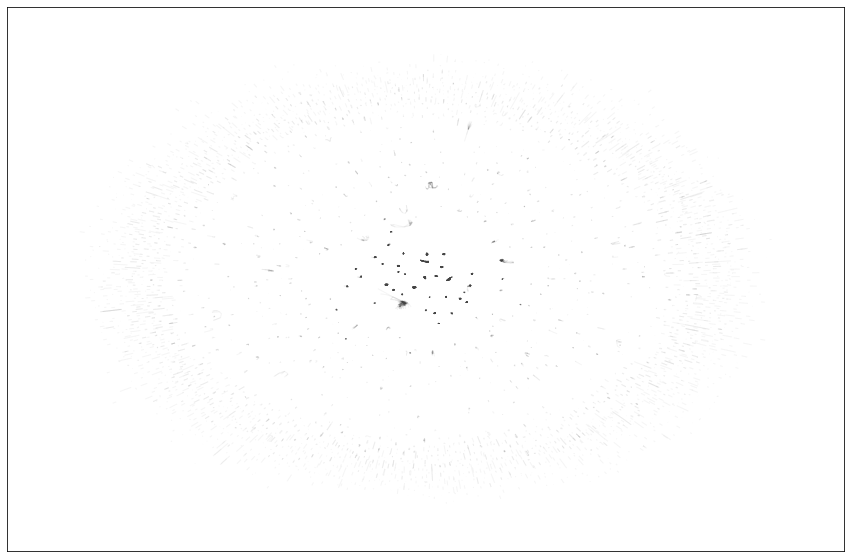

In [27]:
GU = G.to_undirected()
pos = nx.spring_layout(GU, k=0.1)
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    GU,
    pos=pos,
    node_size=0,
    edge_color="#444444",
    alpha=0.05,
    with_labels=False)

## 6. Looking more closely at subgraphs

### Look up the CNSs associated with favorite gene

In [22]:
#Look up the CNSs associated with favorite gene

myGeneID = "Sevir.9G122200" #setaria gt1 = Sevir.9G508000, setaria vrs1 = Sevir.2G379700, setaria ra3 = Sevir.2G407600

cnsIDs = []
total_count = 0

def lines_that_contain(string, fp):
    return [line for line in fp if string in line]

#look up myGeneID in the combinedCNS.csv, and find all of the CNSs for that gene.
with open("combinedCNS.csv", "r") as fp:
    for line in lines_that_contain(myGeneID, fp):
        lineArray = line.split(",")
        cnsID = str(lineArray[0]) + "_" + str(lineArray[1]) + "_" + str(lineArray[2]) #convert CNS into cnsID
        if (G.has_node(cnsID)):
            print(cnsID + ", Connections: " + str(G.degree[cnsID]))
            print("Connected to: " + str(G.adj[cnsID]) + "\n")
            cnsIDs.append(cnsID)
        total_count += 1

print(str(len(cnsIDs)) + " CNSs found for " + str(myGeneID))


Sevir.9G122200_-202_-102, Connections: 1
Connected to: {'Bradi1g11060_-154_-97': {'weight': 1712.0}}

Sevir.9G122200_-4195_-4065, Connections: 2
Connected to: {'Bradi1g11060_-6509_-6381': {'weight': 709.0}, 'Osat.015630237.1_-22243_-22132': {'weight': 757.0}}

Sevir.9G122200_-5381_-5176, Connections: 1
Connected to: {'Osat.015630237.1_-26894_-26675': {'weight': 781.0}}

3 CNSs found for Sevir.9G122200


In [100]:
#subset the graph for cnsID
g = nx.ego_graph(G, "Sevir.9G508000_-10669_-10280", radius=10)

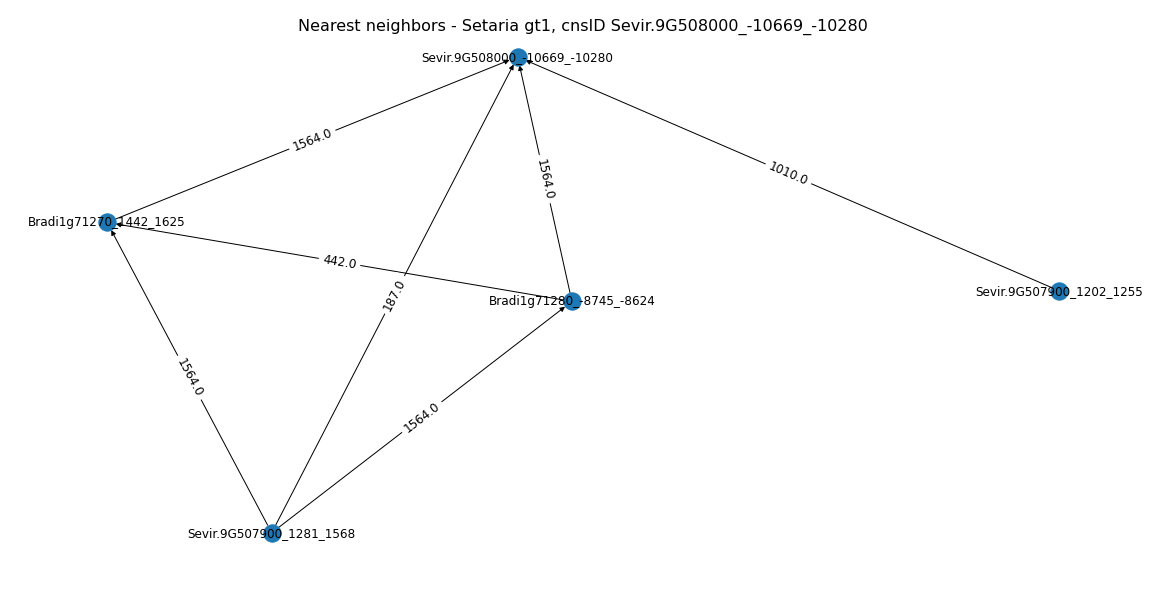

In [123]:
fig = plt.figure("Sevir.9G508000_-10669_-10280", figsize=(16,8))
fig.suptitle("Nearest neighbors - Setaria gt1, cnsID Sevir.9G508000_-10669_-10280", fontsize=16)
pos = nx.spring_layout(g, k=12)
nx.draw(g, pos, with_labels=True, arrows=True, font_size=12)
labels= nx.get_edge_attributes(g, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels,font_size=12)
plt.show()

### Look up CNSs by number of connections

In [ ]:
#sort all nodes in graph by number of connections (most connections at top)
sorted(G.degree, key=lambda x: x[1], reverse=True)

In [ ]:
#subset graph to look at CNS with highest number of connections
g = nx.ego_graph(G, "Bradi1g20520_-830_-746", radius=10)

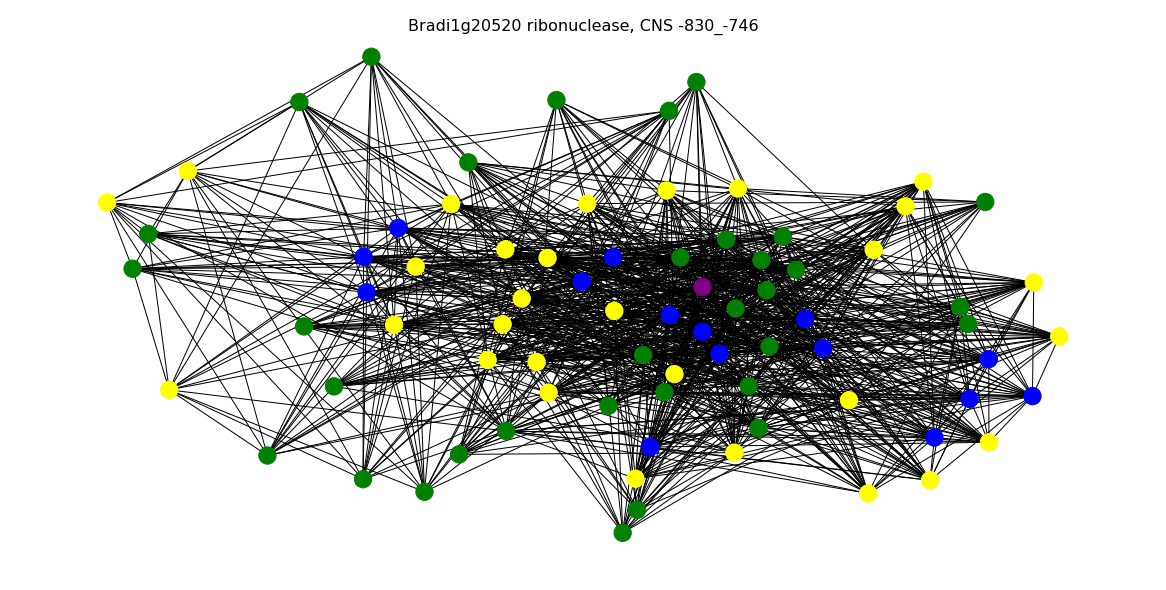

In [49]:
color_map = [] #assign a different color to CNS nodes from different species
for node in g:
    if node == "Bradi1g20520_-830_-746":
        color_map.append('purple') #center node is purple
    elif node[0:3] == "Bra": #Brachypodium
        color_map.append('blue')
    elif node[0:3] == "Sev": #Setaria
        color_map.append('green')
    elif node[0:3] == "Osa": #Rice
        color_map.append('yellow')
    
fig = plt.figure("Bradi1g20520_-830_-746", figsize=(16,8)) #Bradi1g20520 ribonuclease
fig.suptitle("Bradi1g20520 ribonuclease, CNS -830_-746", fontsize=16)
pos = nx.spring_layout(g, weight='weight', k=12)
nx.draw(g, pos, node_color=color_map,with_labels=False)
plt.show()

## 7. Find the shortest paths (blast similarity) between CNS nodes

In [125]:
#use dijkstra's shortest path algorithm to find the shortest weighted path between the source node and all other
#nodes in the graph. Returns two dictionaries keyed by node - a list of predecessors and the distance to node.

#first import a sub graph centered on CNS of interest, keep all connecting nodes within a radius of 10
g = nx.ego_graph(G, "Bradi3g49660_5143_5217", radius=10)

In [126]:
pred, dist = nx.dijkstra_predecessor_and_distance(g, "Bradi3g49660_5143_5217", weight='weight')

In [ ]:
sorted(pred.items()) 
#shortest path to all other nodes. 
#For example, shortest path to Osat.015651458.1_-15348_-15309 is through ['Sevir.5G467400_-8641_-8552', 'Sevir.1G250600_-1108_-1033'].
#There are 2 nodes in between

In [19]:
#sorted(dist.items()) #distances
dict(sorted(dist.items(), key=lambda item: item[1])) #sorted by shortest weight first

{'Bradi3g49660_5143_5217': 0,
 'Sevir.5G467400_-8641_-8552': 719.0,
 'Sevir.1G250600_-1108_-1033': 719.0,
 'Sevir.1G250500_7846_7920': 719.0,
 'Osat.025878880.1_-2083_-1995': 729.0,
 'Sevir.7G111800_303_384': 729.0,
 'Sevir.5G304800_-12681_-12606': 729.0,
 'Sevir.3G178700_515_603': 729.0,
 'Sevir.2G054800_3360_3438': 729.0,
 'Osat.015624938.1_8274_8349': 729.0,
 'Sevir.5G304900_-1905_-1832': 740.0,
 'Sevir.5G443700_1140_1217': 740.0,
 'Osat.015634590.1_363_441': 740.0,
 'Sevir.7G183700_-4462_-4389': 740.0,
 'Sevir.7G183600_1358_1463': 740.0,
 'Sevir.5G317600_569_645': 740.0,
 'Sevir.2G190500_-295_-209': 740.0,
 'Osat.015627641.1_-4983_-4900': 740.0,
 'Sevir.7G111900_677_758': 746.0,
 'Osat.015644836.1_3116_3192': 746.0,
 'Sevir.5G443600_-3499_-3427': 746.0,
 'Sevir.5G317700_-1176_-1101': 746.0,
 'Sevir.3G161700_632_704': 746.0,
 'Sevir.2G265700_495_568': 746.0,
 'Osat.015649124.1_-7657_-7571': 746.0,
 'Osat.015631031.2_-3429_-3344': 746.0,
 'Osat.015614205.1_-15301_-15220': 746.0,
 'Os

In [20]:
#what is the density of the subgraph = sum all the edge weights and then divide by number of edges
x = g.size(weight="weight") #total weight sum
y = g.size() #edge num
x/y

795.6021021021021

In [ ]:
#only keep paths that have max species
speciesNum = 3 # setaria, maize, brachy

#return all paths that are either x-y-z or x-z-y
for n in pred.items():
    if len(n) == speciesNum - 1

In [128]:
newdict = {n: p for n, p in pred.items() if len(p) == 2 and p[0][0:3] != p[1][0:3]}
newdict

{'Bradi3g49671_-110_-24': ['Sevir.5G467400_-8641_-8552',
  'Osat.025878880.1_-2083_-1995']}

In [129]:
source_node = 'Bradi3g49671_-110_-24'
total_species = 3
# returns true if path has different species for all nodes. Node species based off the first 4 CNS id letters.
def uniqueSpeciesPath(sourceNode, endNode, predecessors, numSpecies):
    if (numSpecies != (len(predecessors)+2)):
        return False;
    temp_list = []
    temp_list.append(sourceNode[0:4]) #add starting node
    temp_list.append(endNode[0:4]) #add end node
    for i in predecessors:
        temp_list.append(i[0:4]) #append first 3 chars to list
    return len(np.unique(temp_list)) == numSpecies #does unique num match input number?

for end_n, p in pred.items():
    if uniqueSpeciesPath(source_node, end_n, p, total_species):
        print(source_node, p, end_n)
        print("Distance:", dist[end_n])

Bradi3g49671_-110_-24 ['Sevir.5G467400_-8641_-8552'] Osat.015635777.1_1150_1236
Distance: 1459.0
Bradi3g49671_-110_-24 ['Sevir.2G054800_3360_3438'] Osat.015651185.1_1101_1174
Distance: 1510.0
Bradi3g49671_-110_-24 ['Sevir.2G054800_3360_3438'] Osat.015651213.1_-648_-575
Distance: 1510.0


## 8. Find all shortest paths (blast similarity) in filtered graph between 3 different species

In [175]:
## find shortest paths between different species for all nodes, radius 4
import collections as collections
import random
total_species = 3
conservedPaths = collections.defaultdict(list)

for n in G: #for each node in graph
    g = nx.ego_graph(G, n, radius=4) #make a subgraph radius 4
    pred, dist = nx.dijkstra_predecessor_and_distance(g, n, weight='weight')
    for end_n, p in pred.items():
        if uniqueSpeciesPath(n, end_n, p, total_species):
            node = n
            if n in conservedPaths.keys(): #we dont want duplicates for the same key
                node = n + str(random.random())
            conservedPaths[node].append(dist[end_n])
            conservedPaths[node].append(p)
            conservedPaths[node].append(end_n)

In [176]:
count=0
for n in conservedPaths.items():
    for x in n:
        count +=1
print(count)

10706


In [ ]:
sorted(conservedPaths.values())

In [ ]:
#get key at value
for x in sorted(conservedPaths.values()):
    print(x)
    print(list(conservedPaths.keys())[list(conservedPaths.values()).index(x)])

In [ ]:
#just the start node CNSs
for x in sorted(conservedPaths.values()):
    print(list(conservedPaths.keys())[list(conservedPaths.values()).index(x)])

## 9. Analyzing densities of subgraphs

In [35]:
#what are the densities of all subgraphs of radius 10?
import collections as collections
density = collections.defaultdict(list)
for n in G:
    g = nx.ego_graph(G, n, radius=10)
    x = g.size(weight="weight") #total weight sum
    y = g.size() #edge num
    d = x/y
    density[n].append(d)
    density[n].append(g.size())
    density[n].append(g.order())

In [ ]:
dict(sorted(density.items(), key=lambda item: item[1])) #subgraph density sorted by densest first, then shows edge #, node #

In [ ]:
df = pd.DataFrame.from_dict(density, orient='index', columns=['density', 'edge_num', 'node_num'])
df

### Plotting all subgraphs. x-axis - number of nodes in subgraph, y-axis - number of connections in subgraph, color - density of subgraph

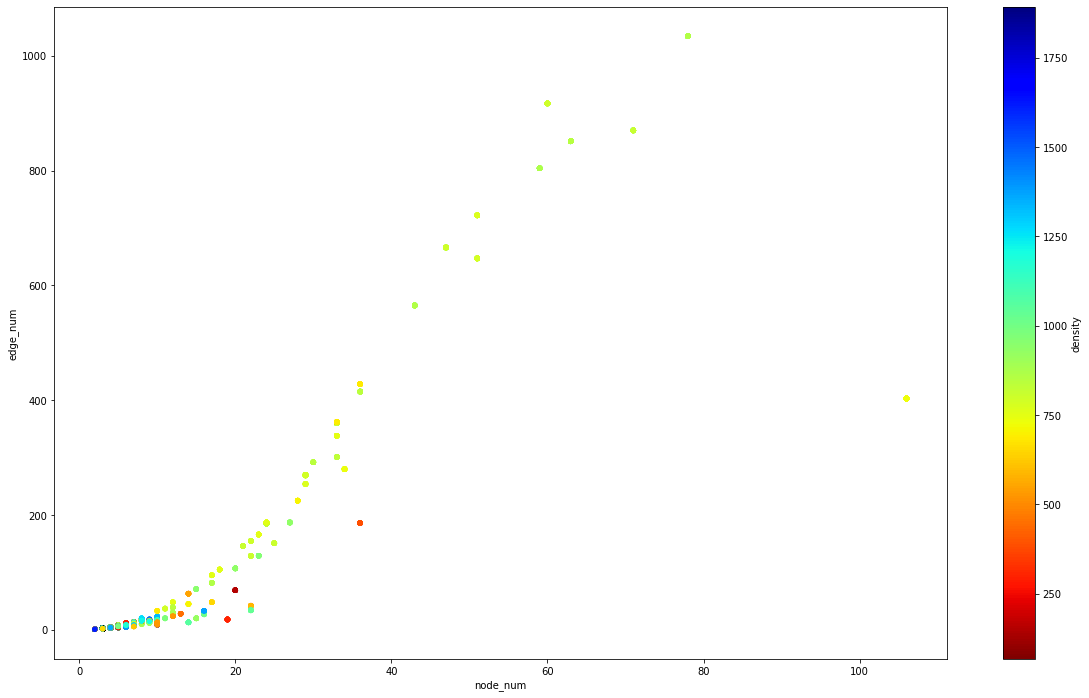

In [87]:
fig,ax=plt.subplots()
df.plot.scatter(x='node_num',y='edge_num',c="density",figsize=(20,12),colormap='jet_r',ax=ax)
plt.show()
#lower density number = more dense

In [ ]:
plt.hist(df['density'],bins=20)
#lower density number=more dense

In [ ]:
plt.hist(df['node_num'],bins=50)

In [ ]:
plt.hist(df['edge_num'],bins=50)